In [1]:
%load_ext autoreload
%autoreload 2

import yaml
import torch
import matplotlib.pyplot as plt

In [24]:
config_file = './configs/lego.yaml'
with open(config_file, 'r') as file:
    config = yaml.safe_load(file)

In [3]:
from utils.DataLoaderLego import DataLoaderLego

data_loader = DataLoaderLego(config['data'])

images, poses, focal = data_loader.getDataset('train')

In [4]:
from utils.Camera import Camera

cameras = []
H, W = images[0].shape[:2] # proBABLY SWAPED

for i in range(images.shape[0]):
    cameras.append(Camera(H, W, poses[i], focal, 'cuda'))


In [5]:
from utils.Renderer import Renderer

renderer = Renderer(config['renderer'])

r1, r2 = cameras[0].getRays()
r1 = r1.expand(r2.shape)

print(r1.device)

points, dists = renderer.getSparsePoints(r1,r2)

points = points.reshape((-1,) + points.shape[2:])
dists = dists.reshape((-1, ) + dists.shape[2:])

cuda:0


In [6]:
from models.TinyNerf import TinyNerf

model = TinyNerf(6)
device = 'cpu'
if torch.cuda.is_available():
    device = torch.cuda.current_device()
model = model.to(device)


6


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
6
Epoch: 0, Loss: 0.11245361715555191, Secs per iter: 0.00694176197052002
Test PSNR: 6.871390342712402
torch.Size([10000, 3])


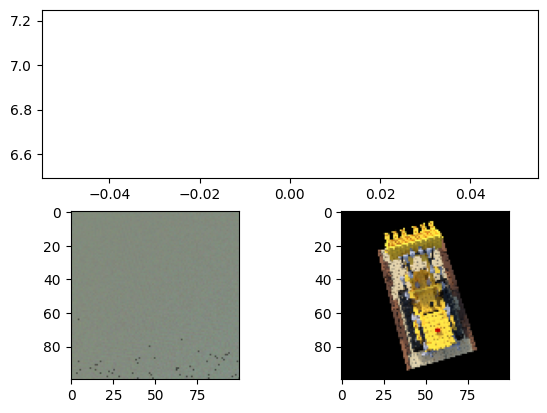

Epoch: 100, Loss: 0.05956985428929329, Secs per iter: 0.12995326280593872
Test PSNR: 11.52861213684082
torch.Size([10000, 3])


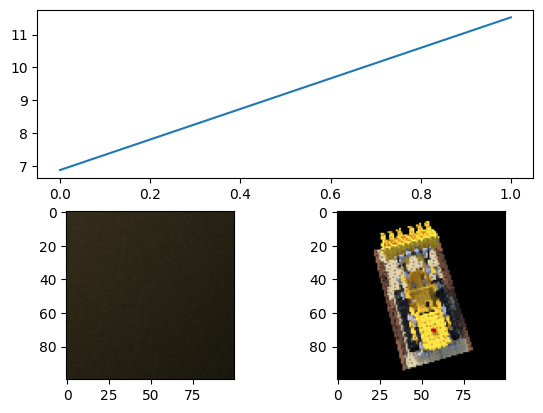

Epoch: 200, Loss: 0.10485300421714783, Secs per iter: 0.132967209815979
Test PSNR: 12.466229438781738
torch.Size([10000, 3])


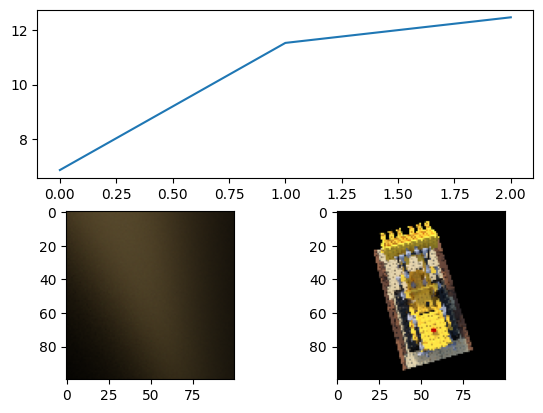

Epoch: 300, Loss: 0.044494591653347015, Secs per iter: 0.13447229862213134
Test PSNR: 13.871801376342773
torch.Size([10000, 3])


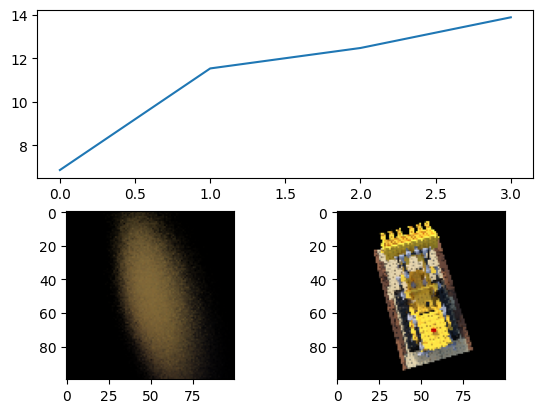

Epoch: 400, Loss: 0.03846294805407524, Secs per iter: 0.13864487886428833
Test PSNR: 15.131404876708984
torch.Size([10000, 3])


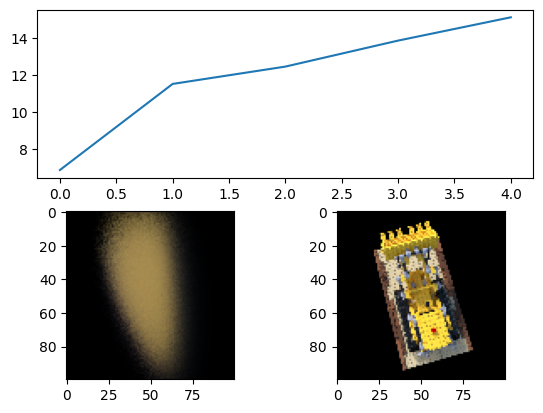

Epoch: 500, Loss: 0.029184997081756592, Secs per iter: 0.13626904010772706
Test PSNR: 15.63671875
torch.Size([10000, 3])


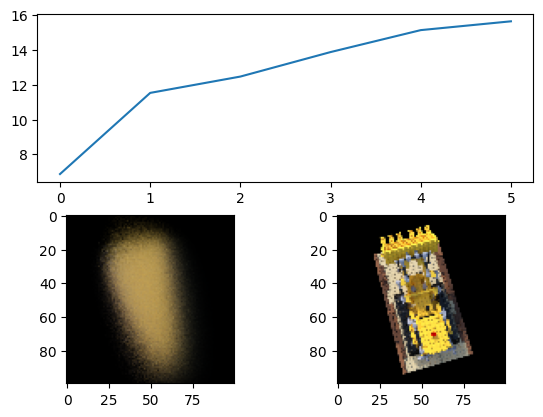

Epoch: 600, Loss: 0.03010299988090992, Secs per iter: 0.13583118915557862
Test PSNR: 15.293787956237793
torch.Size([10000, 3])


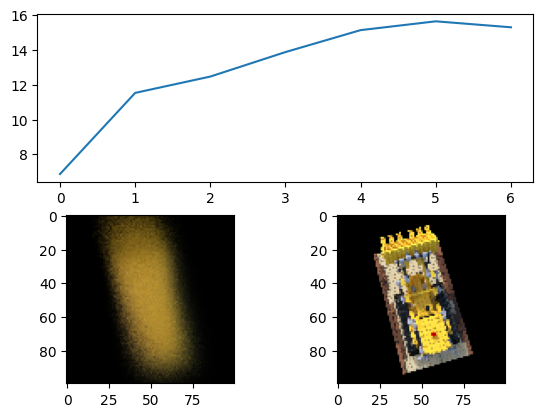

In [ ]:
%load_ext autoreload
%autoreload 2

from utils.TrainerTinyNerf import TrainerTinyNerf
import imageio.v3 as iio

test_img = "nerf_synthetic/lego/val/r_0.png"
test_img = iio.imread(test_img)[:,:,:3]
test_img = torch.tensor(test_img)
test_img = torch.nn.functional.interpolate(test_img[None,...].permute(
            0, 3, 1, 2), (100, 100), mode='bilinear', align_corners=False).permute(0, 2, 3, 1)[0]
test_img = test_img/255

test_pose = torch.tensor([
                [
                    -0.963964581489563,
                    -0.2611401677131653,
                    0.0507759265601635,
                    0.2046843022108078
                ],
                [
                    0.26603081822395325,
                    -0.9462433457374573,
                    0.18398693203926086,
                    0.7416750192642212
                ],
                [
                    7.450580596923828e-09,
                    0.1908649355173111,
                    0.9816163182258606,
                    3.957021951675415
                ],
                [
                    0.0,
                    0.0,
                    0.0,
                    1.0
                ]
            ])

#test_pose = test_pose.to('cuda')
#test_img = test_img.to('cuda')

trainer = TrainerTinyNerf(model, device, images, cameras, renderer, config['trainer'])
trainer.train(test_img[None,...], test_pose[None,...], focal)